# MLOps Demo

Julian Bright, Machine Learning Specialist @ Amazon Web Services


### Overview

In this notebook you will automate an MLOps pipeline build, train, deploy and monitor an XGBoost regression model for predicting the expected taxi fare using the New York City Taxi [dataset](https://registry.opendata.aws/nyc-tlc-trip-records-pds/).

This notebook will take you through a series of steps to execute the AWS CodePipeline stage as depicted below:

![Code pipeline](../docs/code-pipeline.png)

Following a series of steps to trigger demo

1. [Data Prep](#Data-Prep)
2. [Start Build](#Start-Build)
3. [Wait for Training Job](#Wait-for-Training-Job)
4. [Test Dev Deployment](#Test-Dev-Deployment)
5. [Approve Prod Endpoint](#Approve-Prod-Deployment)
6. [Test Prod Deployment](#Test-Prod-Deployment)
7. [Model Monitoring](#Model-Monitoring)
8. [CloudWatch Monitoring](#CloudWatch-Monitoring)

In [1]:
# Import the latest sagemaker and boto3 SDKs
import sys
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install -qU awscli boto3 "sagemaker>=2.0.0" tqdm
!{sys.executable} -m pip show sagemaker

  Using cached pip-21.0-py3-none-any.whl (1.5 MB)
     |████████████████████████████████| 1.5 MB 2.4 MB/s 
Name: sagemaker
Version: 2.24.0
Summary: Open source library for training and deploying models on Amazon SageMaker.
Home-page: https://github.com/aws/sagemaker-python-sdk/
Author: Amazon Web Services
Author-email: None
License: Apache License 2.0
Location: /usr/local/lib/python3.9/site-packages
Requires: google-pasta, protobuf, numpy, smdebug-rulesconfig, importlib-metadata, protobuf3-to-dict, attrs, boto3, packaging
Required-by: 


## Data Prep

Download a sample of the New York City Taxi [dataset](https://registry.opendata.aws/nyc-tlc-trip-records-pds/)

In [2]:
!aws s3 cp 's3://nyc-tlc/trip data/green_tripdata_2018-02.csv' 'nyc-tlc.csv'

download: s3://nyc-tlc/trip data/green_tripdata_2018-02.csv to ./nyc-tlc.csv


Load the dataset into a pandas data frame.

In [3]:
%%time
import pandas as pd

parse_dates= ['lpep_dropoff_datetime', 'lpep_pickup_datetime']
trip_df = pd.read_csv('nyc-tlc.csv', parse_dates=parse_dates)

CPU times: user 2.3 s, sys: 409 ms, total: 2.71 s
Wall time: 2.37 s


Feature engineering to convert dates and add derived duration in minutes

In [4]:
trip_df['duration_minutes'] = (trip_df['lpep_dropoff_datetime'] - trip_df['lpep_pickup_datetime']).dt.seconds/60

Select a sample of columns for our machine learning model

In [5]:
cols = ['total_amount', 'duration_minutes', 'passenger_count', 'trip_distance']
data_df = trip_df[cols]
print(data_df.shape)
data_df.head()

(769940, 4)


,total_amount,duration_minutes,passenger_count,trip_distance
0,23.00,0.050000,1,0.00
1,9.68,7.116667,5,1.60
2,35.76,22.816667,1,9.60
3,5.80,3.166667,1,0.73
4,9.30,6.633333,2,1.87


Exclude any outlines, dropping any null values

In [6]:
data_df = data_df[(data_df.total_amount > 0) & (data_df.total_amount < 200) & 
                  (data_df.duration_minutes > 0) & (data_df.duration_minutes < 120) & 
                  (data_df.trip_distance > 0) & (data_df.trip_distance < 1000) & 
                  (data_df.passenger_count > 0)].dropna()
print(data_df.shape)

(754671, 4)


### Visualize 

Sample and plot distribution of fields

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('fivethirtyeight')

array([[<AxesSubplot:title={'center':'total_amount'}>,
        <AxesSubplot:title={'center':'duration_minutes'}>],
       [<AxesSubplot:title={'center':'passenger_count'}>,
        <AxesSubplot:title={'center':'trip_distance'}>]], dtype=object)

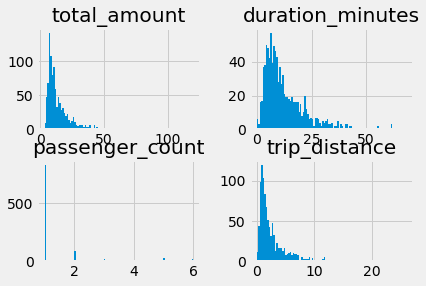

In [8]:
sample_df = data_df.sample(1000)
sample_df.hist(bins=100, layout=(2,2))

Plot duration vs trip distance

<AxesSubplot:xlabel='duration_minutes', ylabel='trip_distance'>

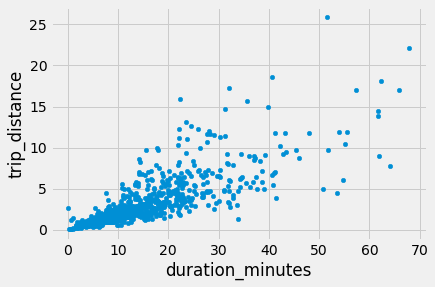

In [9]:
sample_df.plot.scatter(x='duration_minutes', y='trip_distance')

Plot duration vs total amount and we see a similar pattern

<AxesSubplot:xlabel='duration_minutes', ylabel='total_amount'>

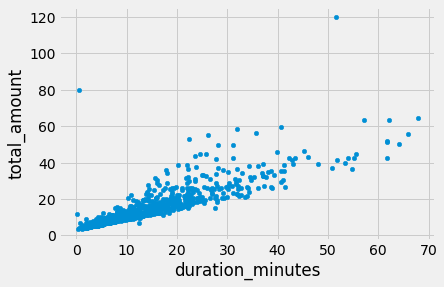

In [10]:
sample_df.plot.scatter(x='duration_minutes', y='total_amount')

We are now ready to split the dataset into train/validation/test sets

In [11]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(data_df, test_size=0.20, random_state=42)
val_df, test_df = train_test_split(val_df, test_size=0.05, random_state=42)

# Set the index for our test dataframe
test_df.reset_index(inplace=True, drop=True)

print('split train: {}, val: {}, test: {} '.format(train_df.shape[0], val_df.shape[0], test_df.shape[0]))

split train: 603736, val: 143388, test: 7547 


Save files as CSV including baseline

In [12]:
%%time

train_cols = ['total_amount', 'duration_minutes','passenger_count','trip_distance']
train_df.to_csv('train.csv', index=False, header=False)
val_df.to_csv('validation.csv', index=False, header=False)

# Save test and baseline with headers
test_df.to_csv('test.csv', index=False, header=True)
train_df.to_csv('baseline.csv', index=False, header=True)

CPU times: user 3.54 s, sys: 142 ms, total: 3.68 s
Wall time: 3.71 s


Upload files to s3

In [13]:
import sagemaker

# Get the session and default bucket
session = sagemaker.session.Session()
bucket = session.default_bucket()

# Specify data previx version
prefix = 'nyc-tlc/v1'

s3_train_uri = session.upload_data('train.csv', bucket, prefix + '/data/training')
s3_val_uri = session.upload_data('validation.csv', bucket, prefix + '/data/validation')
s3_baseline_uri = session.upload_data('baseline.csv', bucket, prefix + '/data/baseline')

## Start Build

Load variables from environment

In [ ]:
import boto3
from botocore.exceptions import ClientError
import os
import time

region = boto3.Session().region_name
artifact_bucket = os.environ['ARTIFACT_BUCKET']
pipeline_name = os.environ['PIPELINE_NAME']
model_name = os.environ['MODEL_NAME']

print('region: {}'.format(region))
print('artifact bucket: {}'.format(artifact_bucket))
print('pipeline: {}'.format(pipeline_name))
print('model name: {}'.format(model_name))

Upload data source meta data to trigger a new build

In [ ]:
from io import BytesIO
import zipfile
import json

input_data = {
    'TrainingUri': s3_train_uri,
    'ValidationUri': s3_val_uri,
    'BaselineUri': s3_baseline_uri
}

hyperparameters = {
    'num_round': 50
}

data_source_key = '{}/data-source.zip'.format(pipeline_name)

zip_buffer = BytesIO()
with zipfile.ZipFile(zip_buffer, 'a') as zf:
    zf.writestr('inputData.json', json.dumps(input_data))
    zf.writestr('hyperparameters.json', json.dumps(hyperparameters))
zip_buffer.seek(0)

s3 = boto3.client('s3')
s3.put_object(Bucket=artifact_bucket, Key=data_source_key, Body=bytearray(zip_buffer.read()))

## Wait for Training Job

Follow the code pipeline to wait until the training job is complete

In [ ]:
from IPython.core.display import HTML

HTML('<a target="_blank" href="https://{0}.console.aws.amazon.com/codesuite/codepipeline/pipelines/{1}/view?region={0}">Code Pipeline</a>'.format(region, pipeline_name))

While we are waiting for the code pipeline to run, let's take a look at the model `run.py` code.  

* We can see the XGBoost SageMaker estimator define in the `get_training_params` method.
* The `training_uri` and  `validation_uri` are loaded from the `inputData.json` file in the data directory.

In [ ]:
!pygmentize ../model/run.py

Once the training and baseline job is complete we can inspect the exeriment metrics.

In [ ]:
from sagemaker import analytics
model_analytics = analytics.ExperimentAnalytics(experiment_name=model_name)
analytics_df = model_analytics.dataframe()

if (analytics_df.shape[0] == 0):
    raise(Exception('Please wait.  No training or baseline jobs'))

pd.set_option('display.max_colwidth', 100) # Increase column width to show full copmontent name
cols = ['TrialComponentName', 'DisplayName', 'SageMaker.InstanceType', 
        'train:rmse - Last', 'validation:rmse - Last'] # return the last rmse for training and validation
analytics_df[analytics_df.columns & cols].head(2)

## Test Dev Deployment

One the endpoint has been deployed and awaiting approval, we can begin some tests.

In [ ]:
codepipeline = boto3.client('codepipeline')

def get_pipeline_stage(pipeline_name, stage_name):
    response = codepipeline.get_pipeline_state(name=pipeline_name)
    for stage in response['stageStates']:
        if stage['stageName'] == stage_name:
            return stage
        
# Get last execution id
deploy_dev = get_pipeline_stage(pipeline_name, 'DeployDev')
if not 'latestExecution' in deploy_dev:
    raise(Exception('Please wait.  Deploy dev not started'))
    
execution_id = deploy_dev['latestExecution']['pipelineExecutionId']
dev_endpoint_name = 'mlops-{}-dev-{}'.format(model_name, execution_id)

print('endpoint name: {}'.format(dev_endpoint_name))

Wait until the dev endpoint is in service (this can take up to 10 minutes)

In [ ]:
sm = boto3.client('sagemaker')

while True:
    try:
        response = sm.describe_endpoint(EndpointName=dev_endpoint_name)
        print("Endpoint status: {}".format(response['EndpointStatus']))
        if response['EndpointStatus'] == 'InService':
            break
    except ClientError as e:
        print(e.response["Error"]["Message"])
    time.sleep(10)

In [ ]:
import numpy as np
from tqdm import tqdm

try:
    # Support SageMaker v2 SDK: https://sagemaker.readthedocs.io/en/stable/v2.html
    from sagemaker.predictor import Predictor
    from sagemaker.serializers import CSVSerializer
    def get_predictor(endpoint_name):
        xgb_predictor = Predictor(endpoint_name)
        xgb_predictor.serializer = CSVSerializer()
        return xgb_predictor
except:
    # Fallback to SageMaker v1.70 SDK
    from sagemaker.predictor import RealTimePredictor, csv_serializer
    def get_predictor(endpoint_name):
        xgb_predictor = RealTimePredictor(endpoint_name)
        xgb_predictor.content_type = 'text/csv'
        xgb_predictor.serializer = csv_serializer
        return xgb_predictor

def predict(predictor, data, rows=500):
    split_array = np.array_split(data, round(data.shape[0] / float(rows)))
    predictions = ''
    for array in tqdm(split_array):
        predictions = ','.join([predictions, predictor.predict(array).decode('utf-8')])
    return np.fromstring(predictions[1:], sep=',')

Invoke the dev endpoint with test data.

In [ ]:
dev_predictor = get_predictor(dev_endpoint_name)
predictions = predict(dev_predictor, test_df[test_df.columns[1:]].values)

Load the response into a data frame, and join with predictions to calculate absolute error.

In [ ]:
pred_df = pd.DataFrame({'total_amount_predictions': predictions })
pred_df = test_df.join(pred_df) # Join on all
pred_df['error'] = abs(pred_df['total_amount']-pred_df['total_amount_predictions'])

We can see some of the largest errors are high predict amount for low trip distance.

In [ ]:
pred_df.sort_values('error', ascending=False).head()

Plot the absoulte error between the total amount vs predicted to visualise outliers.

In [ ]:
ax = pred_df.tail(1000).plot.scatter(x='total_amount_predictions', y='total_amount', 
                                     c='error', title='actual amount vs pred')

Calculate the root means square error for the predicted total

In [ ]:
from math import sqrt
from sklearn.metrics import mean_squared_error

def rmse(pred_df):
    return sqrt(mean_squared_error(pred_df['total_amount'], pred_df['total_amount_predictions']))

print('RMSE: {}'.format(rmse(pred_df)))

## Approve Prod Deployment

If we are happy with this metric, we can go ahead and approve with the widget below, or manually in the CodePipeline  by clicking the "Review" button.

![Code pipeline](../docs/deploy-dev.png)

In [ ]:
import ipywidgets as widgets

def on_click(obj):
    result = { 'summary': approval_text.value, 'status': obj.description }
    response = codepipeline.put_approval_result(
      pipelineName=pipeline_name,
      stageName='DeployDev',
      actionName='ApproveDeploy',
      result=result,
      token=approval_action['token']
    )
    button_box.close()
    print(result)
    
# Create the widget if we are ready for approval
deploy_dev = get_pipeline_stage(pipeline_name, 'DeployDev')
if not 'latestExecution' in deploy_dev['actionStates'][-1]:
    raise(Exception('Please wait.  Deploy dev not complete'))

approval_action = deploy_dev['actionStates'][-1]['latestExecution']
if approval_action['status'] == 'Succeeded':
    print('Dev approved: {}'.format(approval_action['summary']))
elif 'token' in approval_action:
    approval_text = widgets.Text(placeholder='Optional approval message')   
    approve_btn = widgets.Button(description="Approved", button_style='success', icon='check')
    reject_btn = widgets.Button(description="Rejected", button_style='danger', icon='close')
    approve_btn.on_click(on_click)
    reject_btn.on_click(on_click)
    button_box = widgets.HBox([approval_text, approve_btn, reject_btn])
    display(button_box)
else:
    raise(Exception('Please wait.  No dev approval'))

## Test Prod Deployment

The prod deployment will start shortly after approval.

In [ ]:
deploy_prd = get_pipeline_stage(pipeline_name, 'DeployPrd')
if not 'latestExecution' in deploy_prd or not 'latestExecution' in deploy_prd['actionStates'][0]:
    raise(Exception('Please wait.  Deploy prd not started'))
    
execution_id = deploy_prd['latestExecution']['pipelineExecutionId']

Production deployment is managed through a CloudFormation stack which performs the following:

1. Creates SageMaker Endpoint with Data Capture and AutoScaling enabled
2. Creates Model Monitoring Schedule with CloudWatch Alarm
3. Deploys an API Gateway Lambda with AWS Code Deploy

![Code pipeline](../docs/cloud-formation.png)

List the last events and how long ago they occurred.

In [ ]:
from datetime import datetime, timedelta
from dateutil.tz import tzlocal

def get_event_dataframe(events):
    stack_cols = ['LogicalResourceId', 'ResourceStatus', 'ResourceStatusReason', 'Timestamp']
    stack_event_df = pd.DataFrame(events)[stack_cols].fillna('')
    stack_event_df['TimeAgo'] = (datetime.now(tzlocal())-stack_event_df['Timestamp'])
    return stack_event_df.drop('Timestamp', axis=1)

cfn = boto3.client('cloudformation')

stack_name = stack_name='{}-deploy-prd'.format(pipeline_name)
print('stack name: {}'.format(stack_name))

# Get latest stack events
while True:
    try:
        response = cfn.describe_stack_events(StackName=stack_name)
        break
    except ClientError as e:
        print(e.response["Error"]["Message"])
    time.sleep(10)
    
get_event_dataframe(response['StackEvents']).head()

We can send some traffic to the production endpoint now

In [ ]:
prd_endpoint_name='mlops-{}-prd-{}'.format(model_name, execution_id)
print('prod endpoint: {}'.format(prd_endpoint_name))

Wait until the endpoint has finishing updated before we send some traffic

In [ ]:
sm = boto3.client('sagemaker')

while True:
    try:
        response = sm.describe_endpoint(EndpointName=prd_endpoint_name)
        print("Endpoint status: {}".format(response['EndpointStatus']))
        # Wait until the endpoint is in service with data capture enabled
        if response['EndpointStatus'] == 'InService' \
            and 'DataCaptureConfig' in response \
            and response['DataCaptureConfig']['EnableCapture']:
            break
    except ClientError as e:
        print(e.response["Error"]["Message"])
    time.sleep(10)

Send some inference to production endpoint now that data capture is enabled.  Use single records to that monitoring schedule can map to baseline.

In [ ]:
prd_predictor = get_predictor(prd_endpoint_name)
sample_values = test_df[test_df.columns[1:]].sample(100).values
predictions = predict(prd_predictor, sample_values, rows=1)

## Test Rest API

Get back the deployment progress and rest API endpoint

In [ ]:
def get_stack_status(stack_name):
    response = cfn.describe_stacks(StackName=stack_name)
    if response['Stacks']:
        stack = response['Stacks'][0]
        outputs = None
        if 'Outputs' in stack:
            outputs = dict([(o['OutputKey'], o['OutputValue']) for o in stack['Outputs']])
        return stack['StackStatus'], outputs 

outputs = None
while True:
    try:
        status, outputs = get_stack_status(stack_name)
        response = sm.describe_endpoint(EndpointName=prd_endpoint_name)
        print("Endpoint status: {}".format(response['EndpointStatus']))
        if outputs:
            break
        elif status.endswith('FAILED'):
            raise(Exception('Stack status: {}'.format(status)))
    except ClientError as e:
        print(e.response["Error"]["Message"])
    time.sleep(10)

if outputs:
    print('deployment application: {}'.format(outputs['DeploymentApplication']))
    print('rest api: {}'.format(outputs['RestApi']))

Check the deployment application to see if its created and started to shift traffic.

In [ ]:
HTML('<a target="_blank" href="https://{0}.console.aws.amazon.com/codesuite/codedeploy/applications/{1}?region={0}">Deployment Application</a>'.format(region, outputs['DeploymentApplication']))

Now let's ping the REST endpoint to see which SageMaker endpoint it is hitting.  Press STOP when deployment complete

In [ ]:
%%time

from urllib import request

headers = {"Content-type": "text/csv"}
payload = test_df[test_df.columns[1:]].head(1).to_csv(header=False, index=False).encode('utf-8')
rest_api = outputs['RestApi']

while True:
    try:
        resp = request.urlopen(request.Request(rest_api, data=payload, headers=headers))
        print("Response code: %d: endpoint: %s" % (resp.getcode(), resp.getheader('x-sagemaker-endpoint')))
        status, outputs = get_stack_status(stack_name) 
        if status.endswith('COMPLETE'):
            print('Deployment complete\n')
            break
        elif status.endswith('FAILED'):
            raise(Exception('Stack status: {}'.format(status)))
    except ClientError as e:
        print(e.response["Error"]["Message"])
    time.sleep(10)

## Model Monitor

Get the latest production deployment

In [ ]:
deploy_prd = get_pipeline_stage(pipeline_name, 'DeployPrd')
if not 'latestExecution' in deploy_prd:
    raise(Exception('Please wait.  Deploy prd not complete'))
    
execution_id = deploy_prd['latestExecution']['pipelineExecutionId']

### Baseline

Load baseline processing job

In [ ]:
processing_job_name='mlops-{}-pbl-{}'.format(model_name, execution_id)
schedule_name='mlops-{}-pms-{}'.format(model_name, execution_id)

print('processing job name: {}'.format(processing_job_name))
print('schedule name: {}'.format(schedule_name))

In [ ]:
import sagemaker
from sagemaker.model_monitor import BaseliningJob, MonitoringExecution
from sagemaker.s3 import S3Downloader

sagemaker_session = sagemaker.Session()
baseline_job = BaseliningJob.from_processing_name(sagemaker_session, processing_job_name)
status = baseline_job.describe()['ProcessingJobStatus']
if status != 'Completed':
    raise(Exception('Please wait. Processing job not complete, status: {}'.format(status)))
    
baseline_results_uri  = baseline_job.outputs[0].destination

Explore the generated constraints and statistics

In [ ]:
import pandas as pd
import json

baseline_statistics = baseline_job.baseline_statistics().body_dict
schema_df = pd.json_normalize(baseline_statistics["features"])
schema_df.head()

In [ ]:
baseline_constraints = baseline_job.suggested_constraints().body_dict
constraints_df = pd.json_normalize(baseline_constraints["features"])
constraints_df.head()

### View Data Capture

Get the list of data capture files form the endpoint

In [ ]:
bucket = sagemaker_session.default_bucket()
data_capture_logs_uri = 's3://{}/{}/datacapture/{}'.format(bucket, model_name, prd_endpoint_name)

capture_files = S3Downloader.list(data_capture_logs_uri)
print('Found {} files'.format(len(capture_files)))

if capture_files:
    # Get the first line of the most recent file    
    event = json.loads(S3Downloader.read_file(capture_files[-1]).split('\n')[0])
    print('\nLast file:\n{}'.format(json.dumps(event, indent=2)))

### View Monitoring Schedule

The functions for plotting and rendering distribution statistics or constraint violations are implemented in a `utils` file so let's grab that.

In [ ]:
!wget -O utils.py --quiet https://raw.githubusercontent.com/awslabs/amazon-sagemaker-examples/master/sagemaker_model_monitor/visualization/utils.py
import utils as mu

Check the schedule status, and when the next hourly run is.

In [ ]:
sm = boto3.client('sagemaker')

response = sm.describe_monitoring_schedule(MonitoringScheduleName=schedule_name)
print('Schedule Status: {}'.format(response['MonitoringScheduleStatus']))

now = datetime.now(tzlocal())
next_hour = (now+timedelta(hours=1)).replace(minute=0)
scheduled_diff = (next_hour-now).seconds//60
print('Next schedule in {} minutes'.format(scheduled_diff))

Get the latest completed monitoring schedule (which may have violations).

In [ ]:
processing_job_arn = None

while processing_job_arn == None:
    try:
        response = sm.list_monitoring_executions(MonitoringScheduleName=schedule_name)
    except ClientError as e:
        print(e.response["Error"]["Message"])
    for mon in response['MonitoringExecutionSummaries']:
        status = mon['MonitoringExecutionStatus']
        now = datetime.now(tzlocal())
        created_diff = (now-mon['CreationTime']).seconds//60
        print('Schedule status: {}, Created: {} minutes ago'.format(status, created_diff))
        if status in ['Completed', 'CompletedWithViolations']:
            processing_job_arn = mon['ProcessingJobArn']
            break
        if status == 'InProgress':
            break
    else:
        raise(Exception('Please wait.  No Schedules created'))
    time.sleep(10)

Load the monitoring execution

In [ ]:
execution = MonitoringExecution.from_processing_arn(sagemaker_session=sagemaker.Session(), 
                                                    processing_job_arn=processing_job_arn)
exec_inputs = {inp['InputName']: inp for inp in execution.describe()['ProcessingInputs']}
exec_results_uri = execution.output.destination

print('Monitoring Execution results: {}'.format(exec_results_uri))

List the constraints, statistics and violations if they exist. 

In [ ]:
!aws s3 ls $exec_results_uri/

In [ ]:
# Get the baseline and monitoring statistics & violations
baseline_statistics = baseline_job.baseline_statistics().body_dict
execution_statistics = execution.statistics().body_dict
violations = execution.constraint_violations().body_dict['violations']

In [ ]:
mu.show_violation_df(baseline_statistics=baseline_statistics, 
                     latest_statistics=execution_statistics, 
                     violations=violations)

## CloudWatch Monitoring

AWS [CloudWatch Synthetics](https://aws.amazon.com/blogs/aws/new-use-cloudwatch-synthetics-to-monitor-sites-api-endpoints-web-workflows-and-more/) provides allow you to setup a canary to test that your API is returning an expected value on a regular interval.  This is a great way to validate that the blue/green deployment is not causing any downtime for our end-users.

### Create Canary

Let's setup a "canary" to continously test the production API, and a dashboard to visualize the results.

In [ ]:
from urllib.parse import urlparse
from string import Template
from io import BytesIO
import zipfile

# Format the canary_js with rest_api and payload
rest_url = urlparse(rest_api)

with open('canary.js') as f:
    canary_js = Template(f.read()).substitute(hostname=rest_url.netloc, path=rest_url.path, 
                                              data=payload.decode('utf-8').strip())
# Write the zip file
zip_buffer = BytesIO()
with zipfile.ZipFile(zip_buffer, 'w') as zf:
    zip_path = 'nodejs/node_modules/apiCanaryBlueprint.js' # Set a valid path
    zip_info = zipfile.ZipInfo(zip_path)
    zip_info.external_attr = 0o0755 << 16 # Ensure the file is readable
    zf.writestr(zip_info, canary_js)
zip_buffer.seek(0)

# Create the canary
synth = boto3.client('synthetics')

role = sagemaker.get_execution_role()
s3_canary_uri = 's3://{}/{}'.format(artifact_bucket, model_name)
canary_name = 'mlops-{}'.format(model_name)

response = synth.create_canary(
    Name=canary_name,
    Code={
        'ZipFile': bytearray(zip_buffer.read()),
        'Handler': 'apiCanaryBlueprint.handler'
    },
    ArtifactS3Location=s3_canary_uri,
    ExecutionRoleArn=role,
    Schedule={ 
        'Expression': 'rate(10 minutes)', 
        'DurationInSeconds': 0 },
    RunConfig={
        'TimeoutInSeconds': 60,
        'MemoryInMB': 960
    },
    SuccessRetentionPeriodInDays=31,
    FailureRetentionPeriodInDays=31,
    RuntimeVersion='syn-1.0',
)

print('Creating canary: {}'.format(canary_name))

Create the a CloudWatch alarm when success percent drops below 90% for that canary

In [ ]:
cloudwatch = boto3.client('cloudwatch')

canary_alarm_name = '{}-synth-lt-threshold'.format(canary_name)

response = cloudwatch.put_metric_alarm(
    AlarmName=canary_alarm_name,
    ComparisonOperator='LessThanThreshold',
    EvaluationPeriods=1,
    DatapointsToAlarm=1,
    Period=600, # 10 minute interval
    Statistic='Average',
    Threshold=90.0,
    ActionsEnabled=False,
    AlarmDescription='SuccessPercent LessThanThreshold 90%',
    Namespace='CloudWatchSynthetics',
    MetricName='SuccessPercent',
    Dimensions=[
        {
          'Name': 'CanaryName',
          'Value': canary_name
        },
    ],
    Unit='Seconds'
)

print('Creating alarm: {}'.format(canary_alarm_name))

Let's wait for the canary to be read, then start it and wait until running.  The

In [ ]:
while True:
    try:
        response = synth.get_canary(Name=canary_name)
        status = response['Canary']['Status']['State']    
        print('Canary status: {}'.format(status))
        if status == 'ERROR':
            raise(Exception(response['Canary']['Status']['StateReason']))    
        elif status == 'READY':
            synth.start_canary(Name=canary_name)
        elif status == 'RUNNING':
            break        
    except ClientError as e:
        if e.response["Error"]["Code"] == "ResourceNotFoundException":
            print('No canary found.')
            break
        print(e.response["Error"]["Message"])
    time.sleep(10)

# Output a html link to the cloudwatch console
HTML('<a target="_blank" href="https://{0}.console.aws.amazon.com/cloudwatch/home?region={0}#synthetics:canary/detail/{1}">CloudWatch Canary</a>'.format(region, canary_name))

### Create Dashboard

Finally let's create a AWS CloudWatch Dashboard to visualize the key performane metrics and alarms.

In [ ]:
sts = boto3.client('sts')
account_id = sts.get_caller_identity().get('Account')
dashboard_name = 'mlops-{}'.format(model_name)

with open('dashboard.json') as f:
    dashboard_body = Template(f.read()).substitute(region=region, account_id=account_id, model_name=model_name)
    response = cloudwatch.put_dashboard(
        DashboardName=dashboard_name,
        DashboardBody=dashboard_body
    )

# Output a html link to the cloudwatch dashboard
HTML('<a target="_blank" href="https://{0}.console.aws.amazon.com/cloudwatch/home?region={0}#dashboards:name={1}">CloudWatch Dashboard</a>'.format(region, canary_name))

### Trigger Retraining

Our CodePipeline is configured with a [CloudWatch Events](https://docs.aws.amazon.com/codepipeline/latest/userguide/create-cloudtrail-S3-source.html) to start our pipeline for retraining when the drift detection metric alrams.

We can simulate drift by putting metric `0.5` which is above the threshold of `0.2`.  This will trigger the alarm, and start the code pipeline retraining.

Click through to the Alarm and CodePipeline with the links below.

In [ ]:
from datetime import datetime

# Put a new metric to trigger an alaram
response = cloudwatch.put_metric_data(
    Namespace='aws/sagemaker/Endpoints/data-metrics',
    MetricData=[
        {
            'MetricName': 'feature_baseline_drift_total_amount',
            'Dimensions': [
                {
                    'Name': 'MonitoringSchedule',
                    'Value': schedule_name
                },
                {
                    'Name': 'Endpoint',
                    'Value': prd_endpoint_name
                },
            ],
            'Timestamp': datetime.now(),
            'Value': 0.5, # This is over the configured threshold of 0.2
            'Unit': 'None'
        },
    ]
)

# Output a html link to the cloudwatch dashboard
alarm_name = 'mlops-nyctaxi-metric-gt-threshold'
HTML('''<a target="_blank" href="https://{0}.console.aws.amazon.com/cloudwatch/home?region={0}#alarmsV2:alarm/{1}">CloudWatch Alarm</a> starts 
     <a target="_blank" href="https://{0}.console.aws.amazon.com/codesuite/codepipeline/pipelines/{2}/view?region={0}">Code Pipeline</a>'''.format(region, alarm_name, pipeline_name))


## Clean Up

First delete the stacks used as part of the pipeline for deployment, training job and suggest baseline.  For a model name of **nyctaxi** that would be.

* *nyctaxi*-devploy-prd
* *nyctaxi*-devploy-dev
* *nyctaxi*-training-job
* *nyctaxi*-suggest-baseline

The follow code will stop and delete the canary you created

while True:
    try:
        response = synth.get_canary(Name=canary_name)
        status = response['Canary']['Status']['State']    
        print('Canary status: {}'.format(status))
        if status == 'ERROR':
            raise(Exception(response['Canary']['Status']['StateReason']))    
        elif status == 'STOPPED':
            synth.delete_canary(Name=canary_name)
        elif status == 'RUNNING':
            synth.stop_canary(Name=canary_name)
    except ClientError as e:
        if e.response["Error"]["Code"] == "ResourceNotFoundException":
            print('Canary succesfully deleted.')
            break
        print(e.response["Error"]["Message"])
    time.sleep(10)

The following code will delete the dashboard.

cloudwatch.delete_alarms(AlarmNames=[canary_alarm_name])
print('Alarm deleted')

cloudwatch.delete_dashboards(DashboardNames=[dashboard_name])
print('Dashboard deleted')

Finally delete the stack you created for the AWS CodePipeline and Notebook and your done.